In [1]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy.optimize import minimize
from scipy.interpolate import interp1d

In [2]:
# def printattr(name, object):
#     print(name)
# h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_170_gev_with_spanet_KLFitter.h5', "r")
# h5py_file.visititems(printattr)

In [2]:
# Fixed the bins, colors, and tot_event for all plots.
bins = np.arange(100, 301, 2)
bins_dense = np.linspace(100, 300, 1000)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)
JSF_arr = [0.96, 0.98, 1.00, 1.02, 1.04]
JSF_dense = np.linspace(0.96, 1.04, 100)
state_labels = ['Unmatched', 'Incorrect', 'Correct']
lan_gau_fit_labels = ['lan_loc', 'lan_scale', 'gau_loc', 'gau_scale', 'f']
two_gau_fit_labels = ['gau_loc1', 'gau_scale1', 'gau_loc2', 'gau_scale2', 'f']

In [3]:
def get_reco_top_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)*JSF

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)*JSF

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    100 < reco_m_top < 300
    additional cuts (same as CMS)
    """
    # Caululate delR
    lepton_eta = h5py_file['lepton_features/eta'][:]
    lepton_phi = h5py_file['lepton_features/phi'][:]
    jet_eta = h5py_file['jet_features/eta'][:]
    jet_phi = h5py_file['jet_features/phi'][:]
    del_eta = np.array([jet_eta[i, :4] - lepton_eta[i] for i in range(len(jet_eta))])
    del_phi = np.abs([jet_phi[i, :4] - lepton_phi[i] for i in range(len(jet_eta))])
    del_phi = np.where(del_phi < np.pi, del_phi, 2*np.pi-del_phi)
    delR = np.sqrt(del_eta**2 + del_phi**2)

    # cuts
    # pid 11 is electron, 13 is muon.
    cut_reco_top = np.logical_and(dic['reconstructed_top_mass'] > 100, dic['reconstructed_top_mass'] < 300)
    cut_lepton_pt = np.logical_or(
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 26, h5py_file['lepton_features/pid'][:] == 13),
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 29, h5py_file['lepton_features/pid'][:] == 11))
    cut_lepton_eta = np.abs(h5py_file['lepton_features/eta'][:]) < 2.4
    cut_delR = np.logical_or(np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 13, delR[:, 0] > 0.4, delR[:, 1] > 0.4, delR[:, 2] > 0.4, delR[:, 3] > 0.4)),
            np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 11, delR[:, 0] > 0.3, delR[:, 1] > 0.3, delR[:, 2] > 0.3, delR[:, 3] > 0.3)))
    cut_jet_pt = h5py_file['jet_features/pt'][:, 3] > 30
    cut_jet_eta = np.logical_and.reduce((abs(h5py_file['jet_features/eta'][:, 0]) < 2.4, abs(h5py_file['jet_features/eta'][:, 1]) < 2.4,
                                        abs(h5py_file['jet_features/eta'][:, 2]) < 2.4, abs(h5py_file['jet_features/eta'][:, 3]) < 2.4))
    cut_first4_btag = np.sum(h5py_file['jet_features/btag'][:, :4], axis=1) == 2
    cuts = np.logical_and.reduce((cut_reco_top, cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    a = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    b = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    a_or_b = np.logical_or(a, b)
    right = np.logical_and(a_or_b, h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(right, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, cuts, h5py_file['klfitter/score/loglikelihood'][:]
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, cuts, h5py_file['spanet/right_target/detection'][:]

In [4]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_spanet_dic, state_spanet_dic, cut_spanet_dic = {}, {}, {}
reco_klf_dic, state_klf_dic, cut_klf_dic = {}, {}, {}
loglikeli_klf_dic, detection_spanet_dic = {}, {}

for m in mass:
    for JSF in JSF_arr:
        h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")
        reco_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)], cut_spanet_dic[(m, JSF)], detection_spanet_dic[(m, JSF)] = get_reco_top_mass(h5py_file, 'spanet', JSF)
        reco_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]  = get_reco_top_mass(h5py_file, 'klfitter', JSF)

/tmp/ipykernel_36815/2208267343.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2


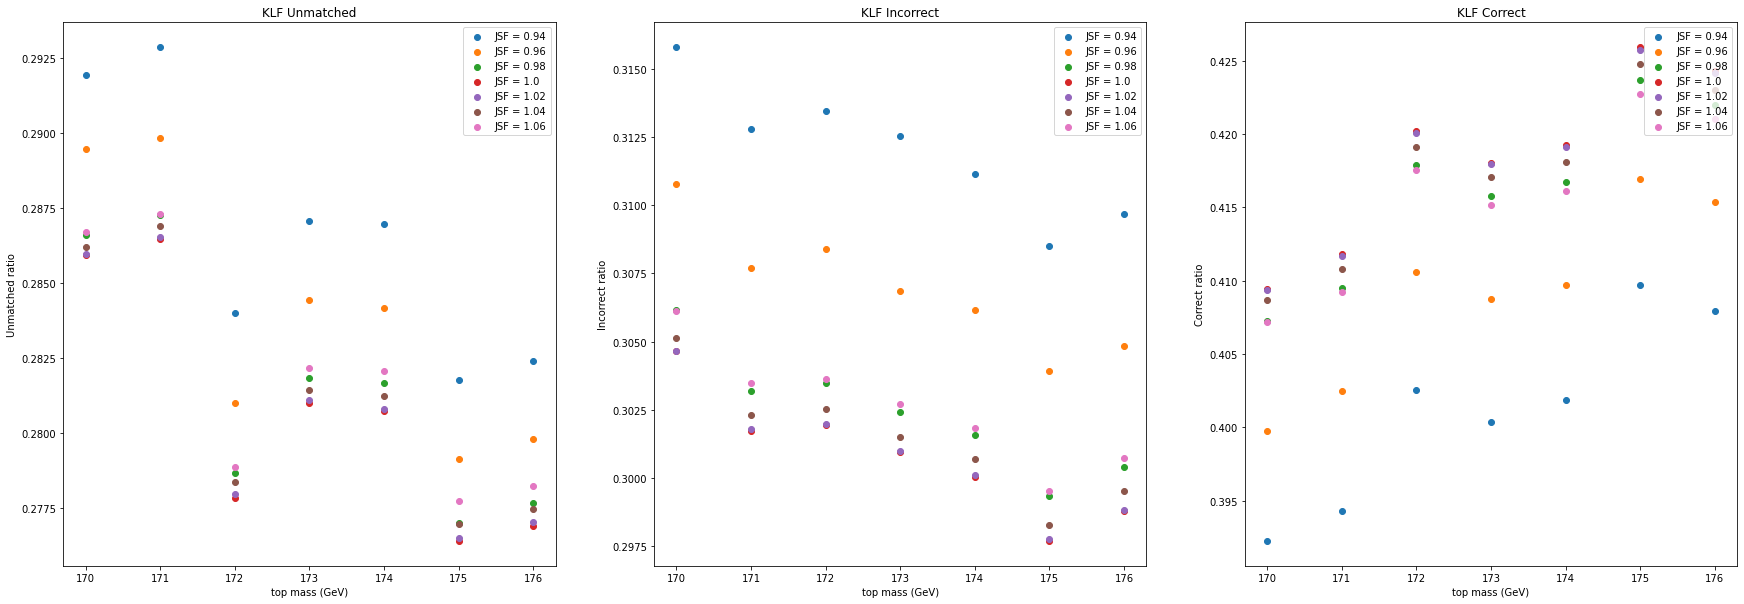

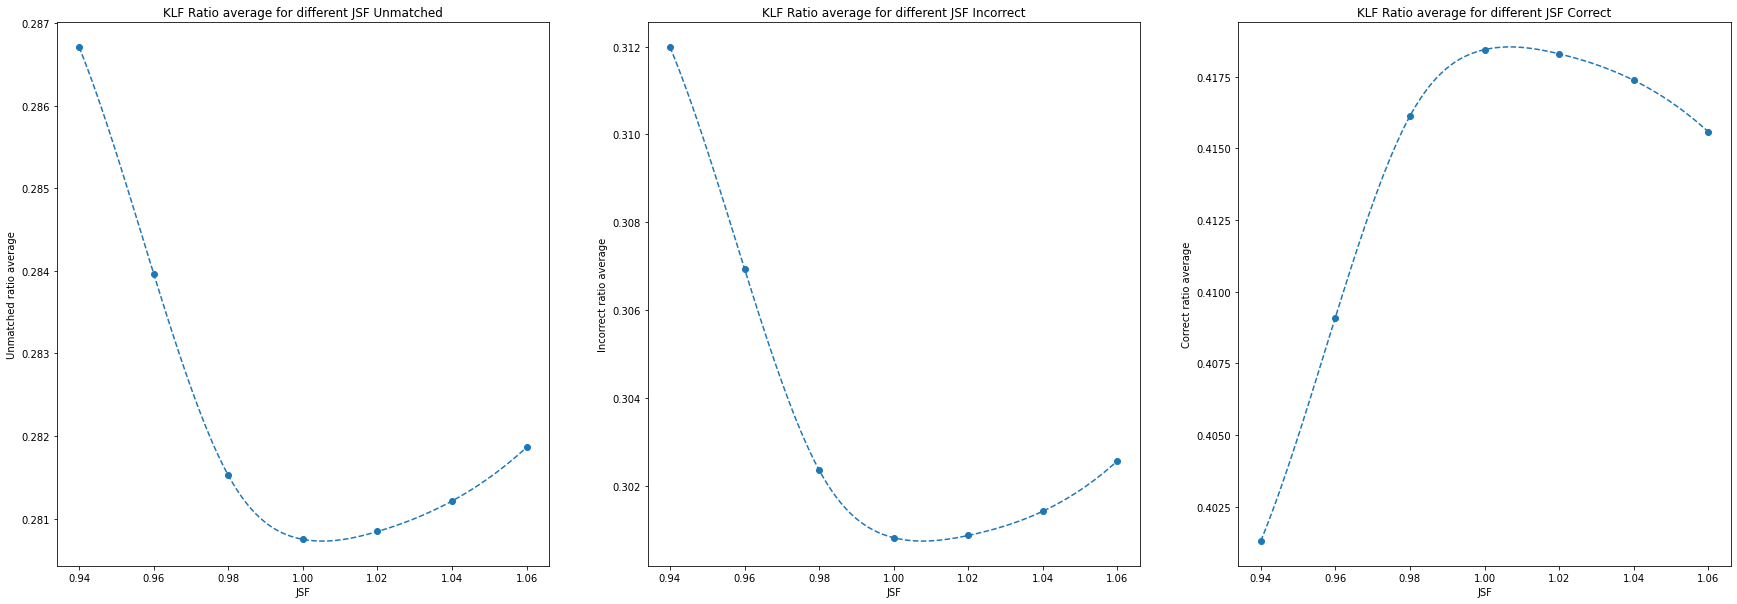

In [5]:
ratio_klf_dic = defaultdict(list)
plt.figure(figsize=(30,10))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*44
    for JSF in JSF_arr:
        for state_i in [2, 1, 0]:
            ratio = np.count_nonzero(state_klf_dic[(m, JSF)][np.logical_and(cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>-70)]==state_i)/len(state_klf_dic[(m, JSF)][np.logical_and(cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>-70)])
            ratio_klf_dic[(JSF, state_i)].append(ratio)

for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)

    for JSF in JSF_arr:
        plt.scatter(mass, ratio_klf_dic[(JSF, state_i)], label='JSF = {}'.format(JSF))
    plt.title('KLF ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel(state_labels[state_i] + ' ratio')
    plt.legend(loc='upper right')
plt.show()

fJSF_klf_dic = {}
plt.figure(figsize=(30,10))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(JSF_arr, [np.mean(ratio_klf_dic[(JSF, state_i)]) for JSF in JSF_arr])
    f = interp1d(JSF_arr, [np.mean(ratio_klf_dic[(JSF, state_i)]) for JSF in JSF_arr], kind='cubic')
    fJSF_klf_dic[state_i] = f
    plt.plot(JSF_dense, f(JSF_dense), '--')
    plt.title('KLF Ratio average for different JSF ' + state_labels[state_i])
    plt.xlabel('JSF')
    plt.ylabel(state_labels[state_i] + ' ratio average')
plt.show()

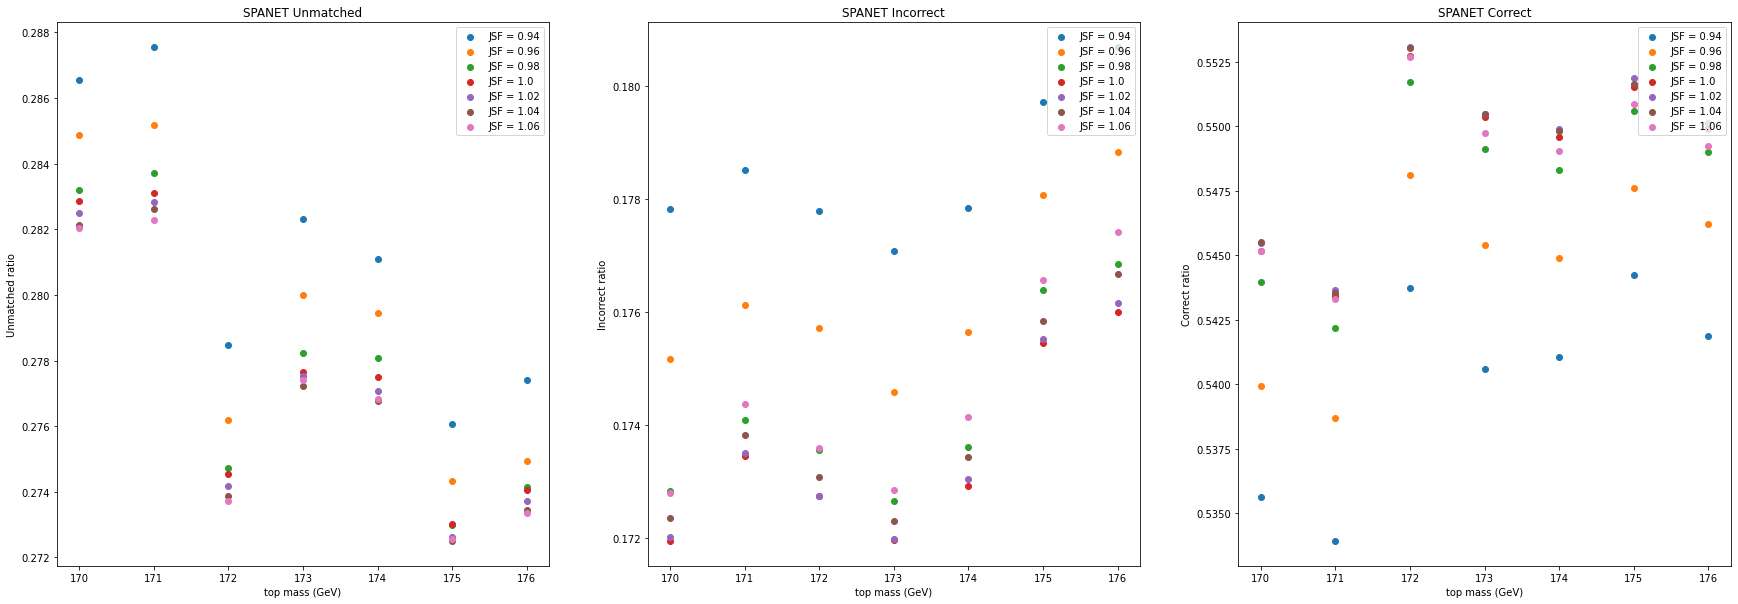

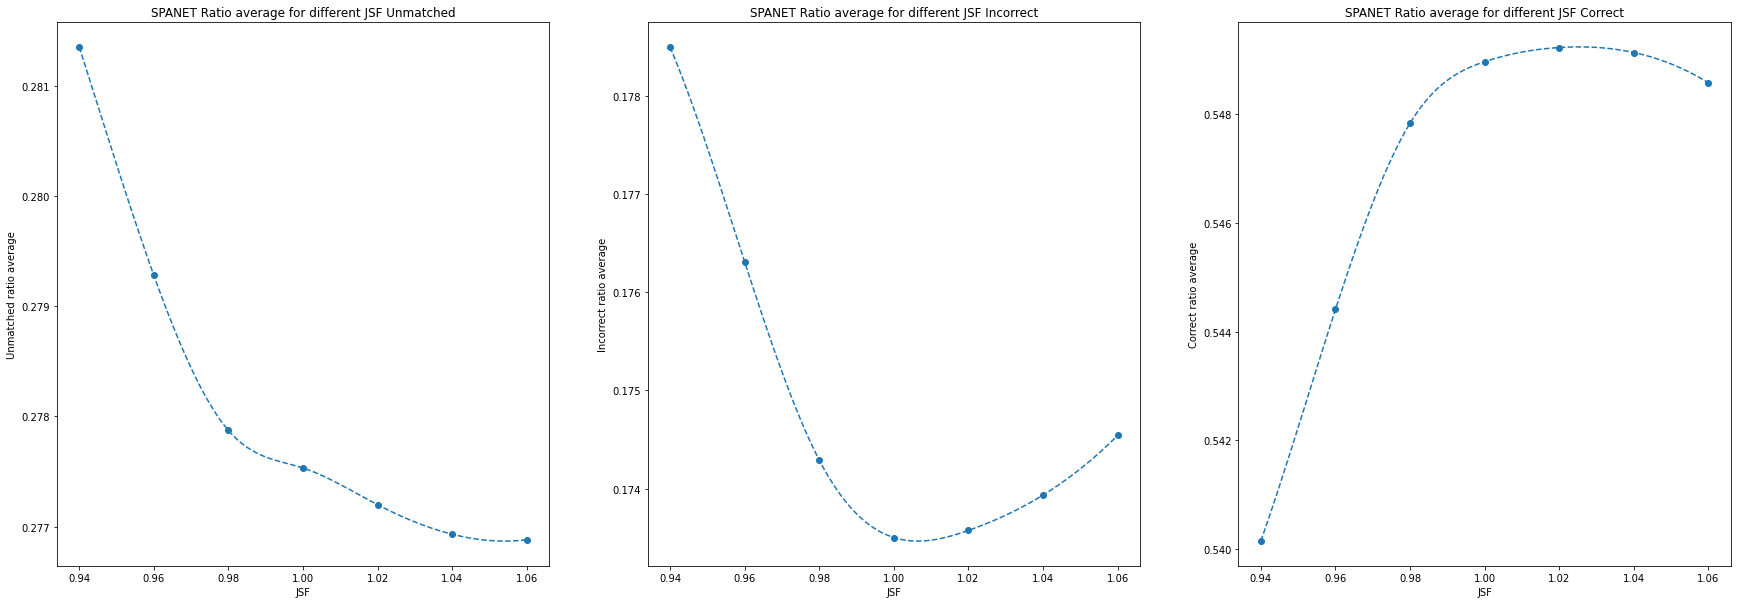

In [6]:
ratio_spanet_dic = defaultdict(list)
plt.figure(figsize=(30,10))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*44
    for JSF in JSF_arr:
        for state_i in [2, 1, 0]:        
            ratio = np.count_nonzero(state_spanet_dic[(m, JSF)][np.logical_and(cut_spanet_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>-70)]==state_i)/len(state_spanet_dic[(m, JSF)][np.logical_and(cut_spanet_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>-70)])
            ratio_spanet_dic[(JSF, state_i)].append(ratio)

for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)

    for JSF in JSF_arr:
        plt.scatter(mass, ratio_spanet_dic[(JSF, state_i)], label='JSF = {}'.format(JSF))
    plt.title('SPANET ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel(state_labels[state_i] + ' ratio')
    plt.legend(loc='upper right')
plt.show()

fJSF_spanet_dic = {}
plt.figure(figsize=(30,10))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(JSF_arr, [np.mean(ratio_spanet_dic[(JSF, state_i)]) for JSF in JSF_arr])
    f = interp1d(JSF_arr, [np.mean(ratio_spanet_dic[(JSF, state_i)]) for JSF in JSF_arr], kind='cubic')
    fJSF_spanet_dic[state_i] = f
    plt.plot(JSF_dense, f(JSF_dense), '--')
    plt.title('SPANET Ratio average for different JSF ' + state_labels[state_i])
    plt.xlabel('JSF')
    plt.ylabel(state_labels[state_i] + ' ratio average')
plt.show()

In [7]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized version
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# One gaussian distribution.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Two gaussian distributions.
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Linear
def linear(x, a, b):
    return a*x+b

def linear2(x, a, b, c):
    return a*x[0] + b*x[1] + c

def chi2_pdf(observed, pdf): #mt1 is the observation, n2 is the height of the bins from pdf.
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*2*len(observed)
    return np.sum((n1-n2)**2/n2)

def loglikeli_two_gauss(popt, fit_target): return -2*np.sum(np.log(two_gau_norm(fit_target, *popt)))
def loglikeli_langau(popt, fit_target): return -2*np.sum(np.log(langau_norm(fit_target, *popt)))

In [2]:
param_cut_dic = {}

# Fit every class to landau gaussian
fita_spanet_dic, fitb_spanet_dic, fitb_spanet_dic = {}, {}, {}
fit_popt_dic = {}
fit_perr_dic = {}
popt_spanet_arr = {}
perr_spanet_arr = {}

for state_i in [0, 1, 2]:
    for m in mass:
        plt.figure(figsize=(30, 30))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(3, 3, i+1)
            fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, loglikeli_klf_dic[(m, JSF)]>-70))]
            hist, bin_edges = np.histogram(fit_target, bins=bins, density=True)
            # 2Gaussian for correct
            if state_i == 2:
                popt, pcov = optimize.curve_fit(two_gau_norm, bin_edges[:-1]+1, hist, p0=(150, 20, 170, 20, 0.9), bounds=((140, 10, 140, 10, 0), (200, 30, 200, 30, 1)))
                y_dense = two_gau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, two_gau_norm(bins[:-1]+1, *popt))
            
            # Landau + Gaussian for incorrect and unmatch
            else:
                popt, pcov = optimize.curve_fit(langau_norm, bin_edges[:-1]+1, hist, p0=(150, 20, 160, 20, 0.9), bounds=((140, 10, 140, 10, 0), (160, 30, 250, 30, 1)))
                y_dense = langau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, langau_norm(bins[:-1]+1, *popt))

            fit_popt_dic[(m, JSF)] = popt
            fit_perr_dic[(m, JSF)] = np.sqrt(np.diag(pcov))
            plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=2, color='None', label = state_labels[state_i] + 'histogram')
            plt.plot(bins_dense, y_dense, c='r', label='chi2 = {:.2f}'.format(chi2))
            plt.xlim(100, 300)
            plt.title('spanet {}, Top mass = {}, JSF = {}'.format(state_labels[state_i], m, JSF))
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/2GeV')
            plt.legend()
        plt.show()

    # popt_spanet_arr = np.transpose(np.array(popt_spanet_arr))
    # fit_popt_dic[state_i] = popt_spanet_arr
    # perr_spanet_arr = np.transpose(np.array(perr_spanet_arr))
    # fita_spanet_arr, fitb_spanet_arr = [], []

    # plt.figure(figsize=(20, 10))
    # for i, arr in enumerate(popt_spanet_arr):
    #     plt.subplot(2, 3, i+1)
    #     popt, pcov = optimize.curve_fit(linear, [mass, JSF], arr, method="lm")
    #     perr = np.sqrt(np.diag(pcov))
    #     plt.errorbar(mass, arr, yerr = perr_spanet_arr[i])
    #     param_cut_dic[(-70, i)] = arr
    #     y = linear(top_mass_arr, popt[0], popt[1])
    #     plt.plot(top_mass_arr, y)
    #     plt.xlabel('True top mass (GeV)')
    #     if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
    #     else: plt.ylabel(lan_gau_fit_labels[i])
    #     plt.title('spanet {}, loglikelihood > -70'.format(state_labels[state_i]))
    #     fita_spanet_arr.append(popt[0])
    #     fitb_spanet_arr.append(popt[1])
    # plt.show()
    # fita_spanet_dic[state_i] = fita_spanet_arr
    # fitb_spanet_dic[state_i] = fitb_spanet_arr

NameError: name 'mass' is not defined

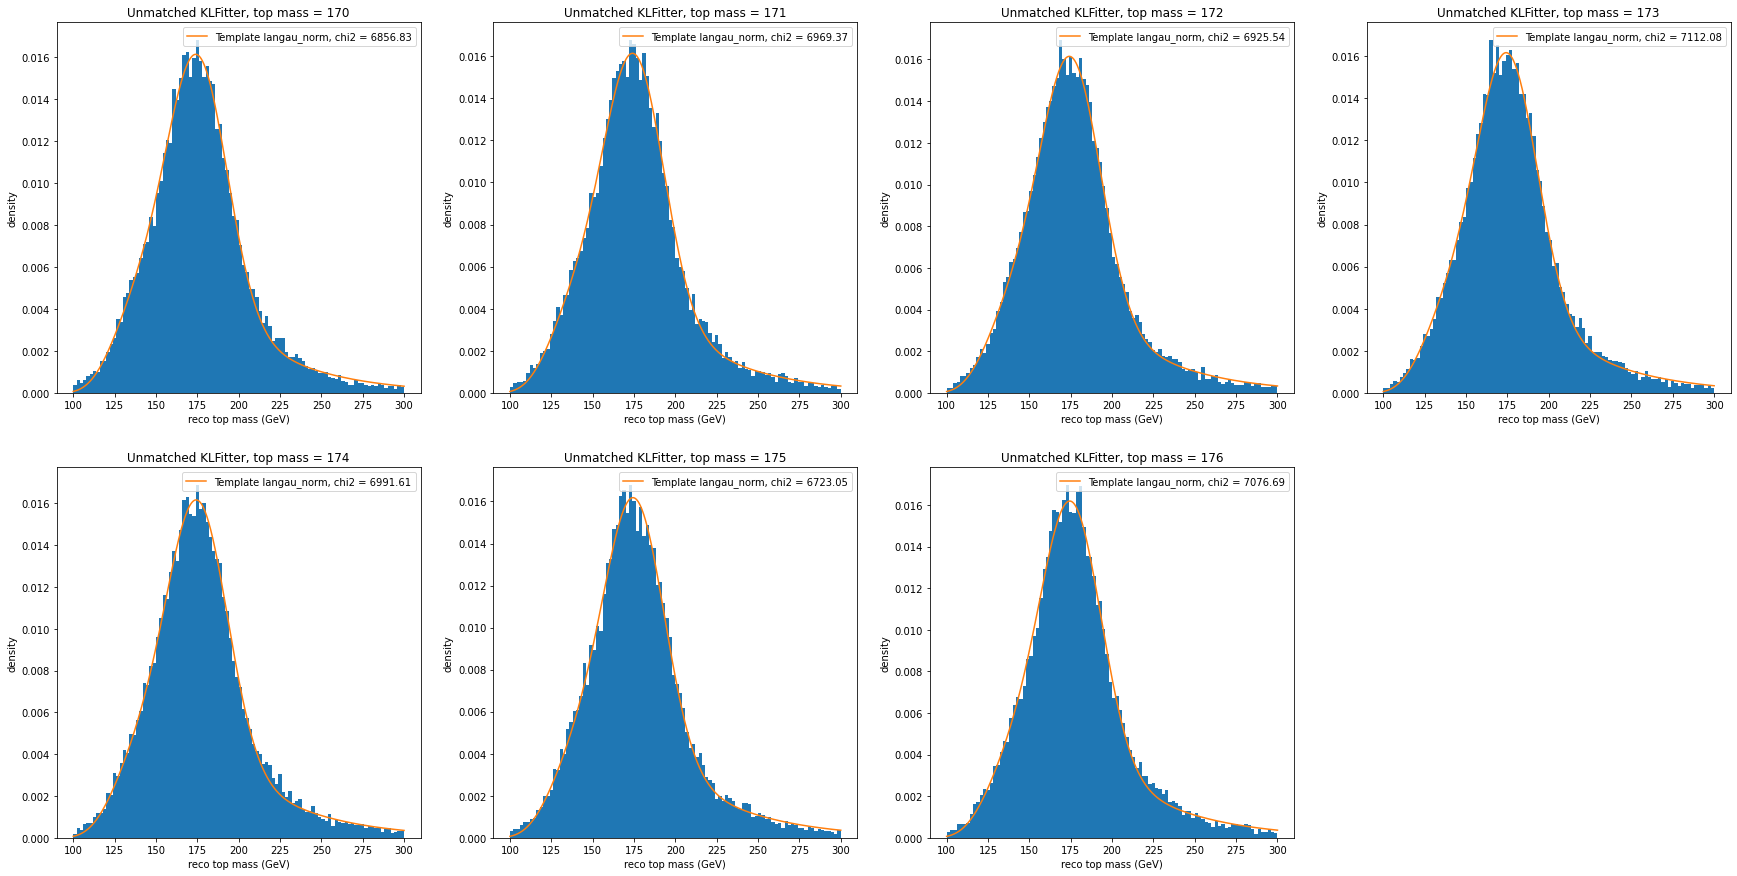

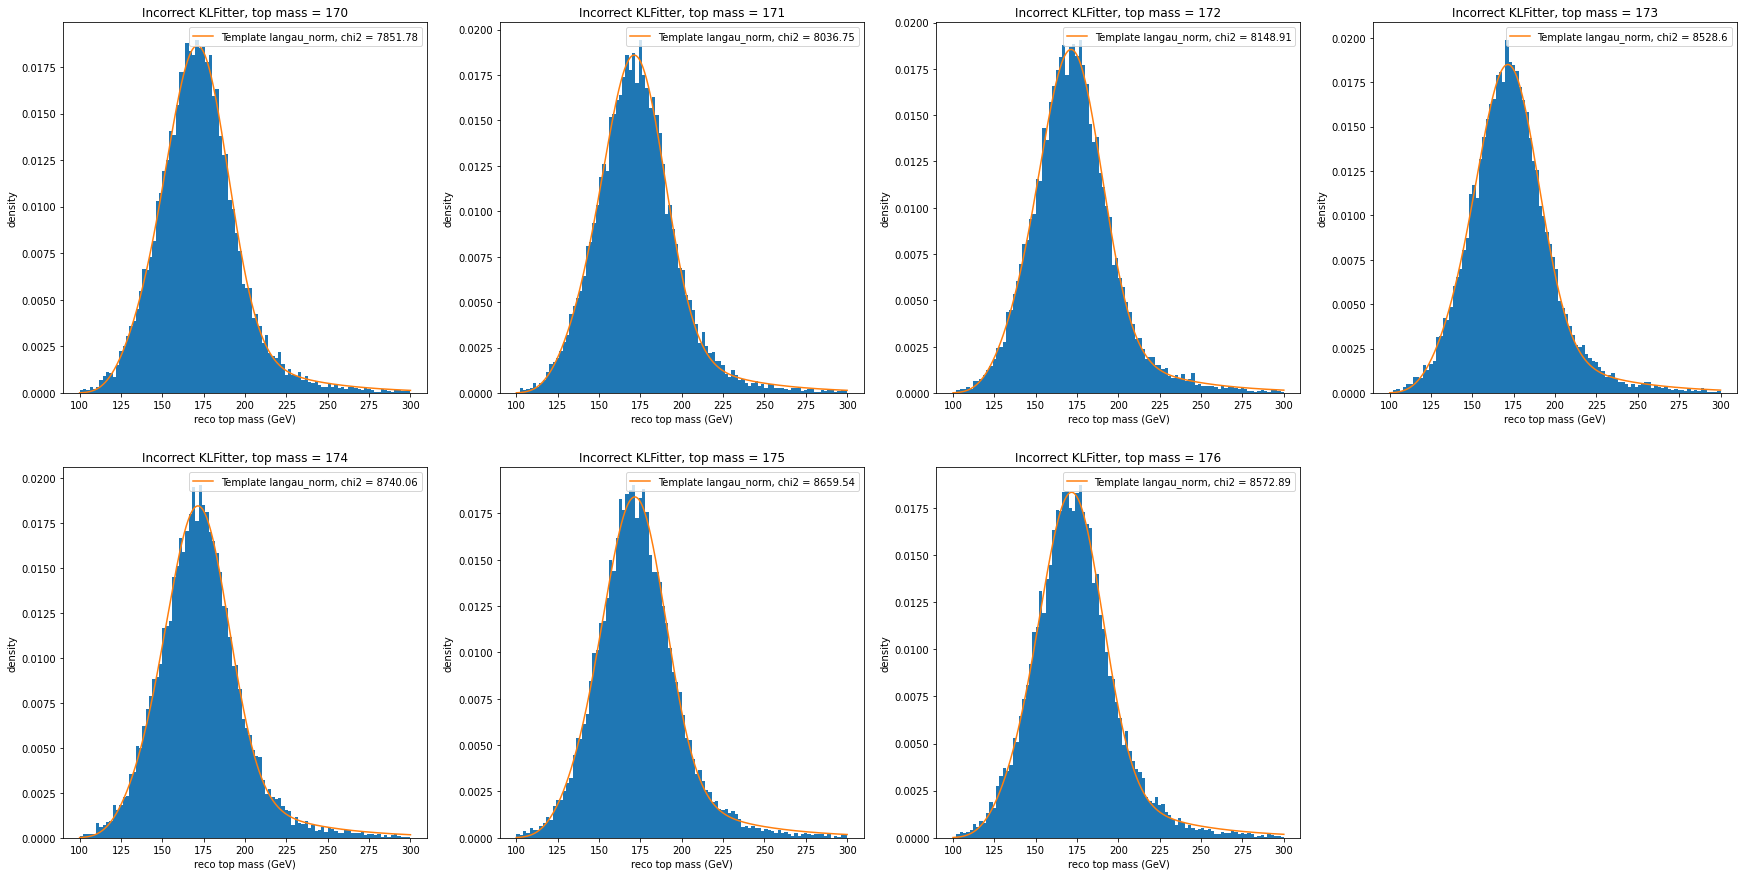

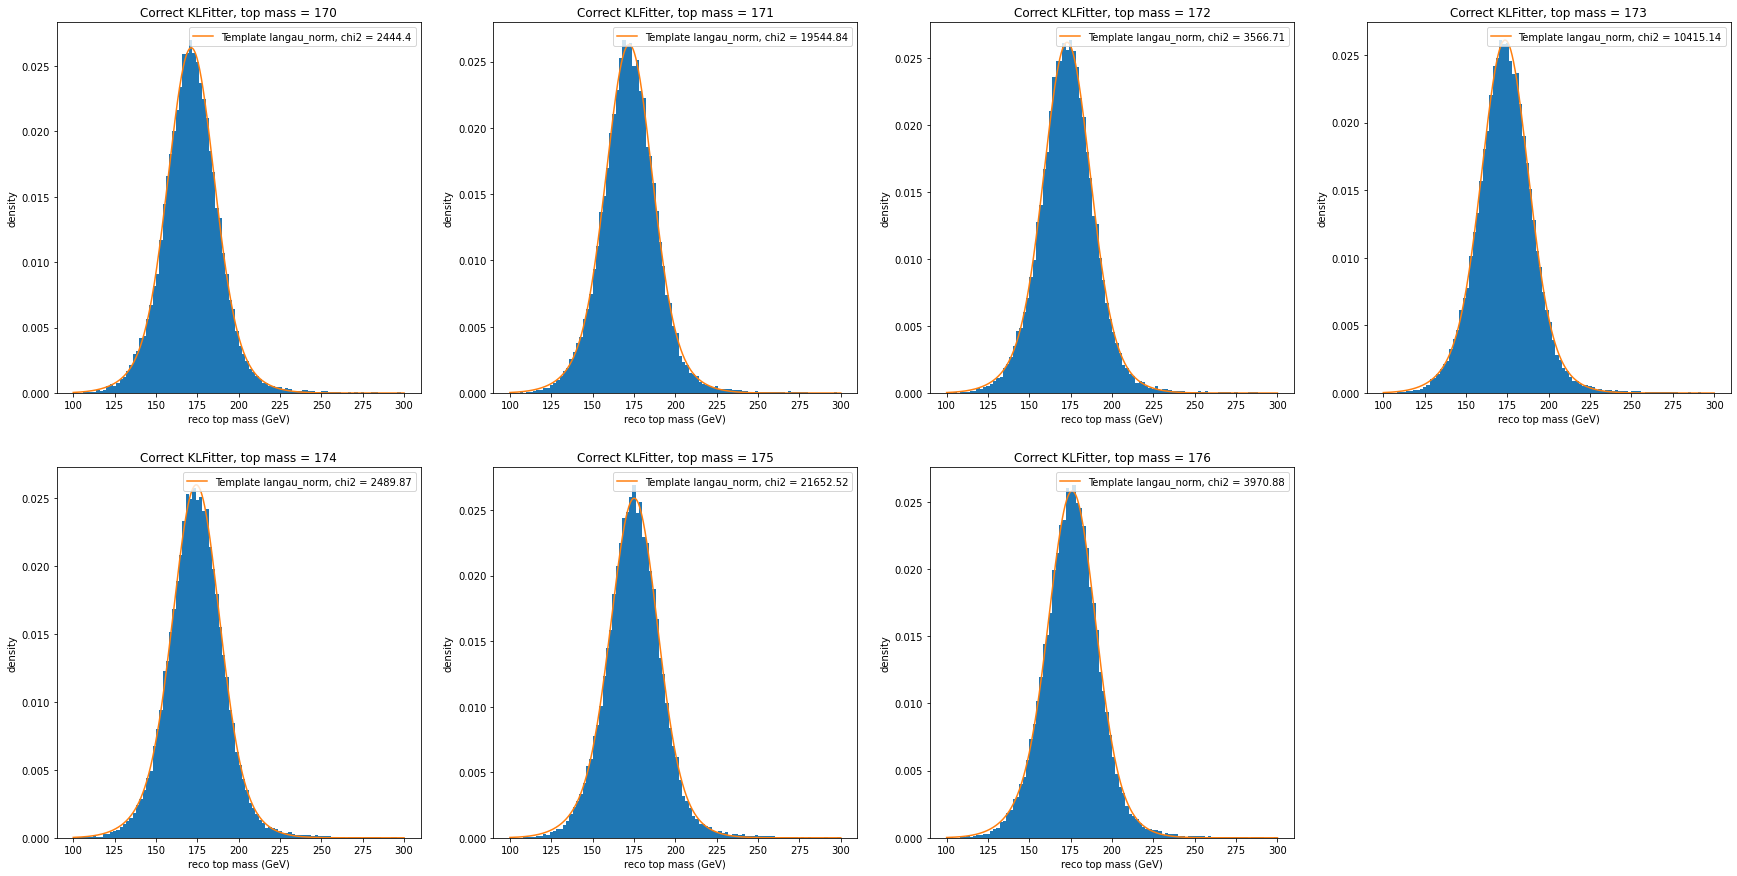

In [15]:
# for state_i in [0, 1, 2]:
#     plt.figure(figsize=(30,15))
#     for i, m in enumerate(mass):
#         plt.subplot(2, 4, i+1)
#         hist, bin_edges = np.histogram(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, loglikeli_klf_dic[m]>-70))], bins=bins, density=True)
#         popt = np.array(fita_spanet_dic[state_i])*m+fitb_spanet_dic[state_i]
#         if state_i  == 2:
#             y_template_dense_norm = two_gau_norm(bins_dense, *popt)
#             chi_template_norm = chi2_pdf(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, loglikeli_klf_dic[m]>-70))], two_gau_norm(bins[:-1]+1, *popt))
#         else:
#             y_template_dense_norm = langau_norm(bins_dense, *popt)
#             chi_template_norm = chi2_pdf(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], state_klf_dic[m] == state_i, loglikeli_klf_dic[m]>-70))], langau_norm(bins[:-1]+1, *popt))

#         plt.hist(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, loglikeli_klf_dic[m]>-70))], bins=bins, density=True)
#         plt.plot(bins_dense, y_template_dense_norm, label='Template langau_norm, chi2 = {}'.format(round(chi_template_norm, 2)))
#         plt.title(state_labels[state_i] + ' KLFitter, top mass = {}'.format(m))
#         plt.xlabel('reco top mass (GeV)')
#         plt.ylabel('density')
#         plt.legend(loc='upper right')
#     plt.show()

In [43]:
# for state_i in [0, 1, 2]:
#     plt.figure(figsize=(30,15))
#     for i, m in enumerate(mass):
#         plt.subplot(2, 4, i+1)
#         hist, bin_edges = np.histogram(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, loglikeli_klf_dic[m]>-70))], bins=bins, density=True)
#         popt = np.array(fita_spanet_dic[state_i])*m+fitb_spanet_dic[state_i]
#         if state_i  == 2:
#             y_template_dense_norm = two_gau_norm(bins_dense, *popt)
#             chi_template_norm = chi2_pdf(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, loglikeli_klf_dic[m]>-70))], two_gau_norm(bins[:-1]+1, *popt))
#         else:
#             y_template_dense_norm = langau_norm(bins_dense, *popt)
#             chi_template_norm = chi2_pdf(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, loglikeli_klf_dic[m]>-70))], langau_norm(bins[:-1]+1, *popt))

#         plt.hist(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_spanet_dic[m] == state_i, loglikeli_klf_dic[m]>-70))], bins=bins, density=True)
#         plt.plot(bins_dense, y_template_dense_norm, label='Template langau_norm, chi2 = {}'.format(round(chi_template_norm, 2)))
#         plt.title(state_labels[state_i] + ' SPANET, top mass = {}'.format(m))
#         plt.xlabel('reco top mass (GeV)')
#         plt.ylabel('density')
#         plt.legend(loc='upper right')
#     plt.show()

In [17]:
def combine_klf_pdf(m):
    fraction = [np.mean(ratio_klf_dic[i]) for i in [0, 1, 2]]
    hist = [0]*len(bins[:-1])
    for state_i in [0, 1, 2]:
        popt = np.array(fita_klf_dic[state_i])*m+fitb_klf_dic[state_i]
        if state_i == 2: hist += two_gau_norm(bins[:-1]+1, *popt)*fraction[state_i]
        else: hist += langau_norm(bins[:-1]+1, *popt)*fraction[state_i]
    return hist

def combine_spanet_pdf(m):
    fraction = [np.mean(ratio_spanet_dic[i]) for i in [0, 1, 2]]
    hist = [0]*len(bins[:-1])
    for state_i in [0, 1, 2]:
        popt = np.array(fita_spanet_dic[state_i])*m+fitb_spanet_dic[state_i]
        if state_i == 2: hist += two_gau_norm(bins[:-1]+1, *popt)*fraction[state_i]
        else: hist += langau_norm(bins[:-1]+1, *popt)*fraction[state_i]
    return hist

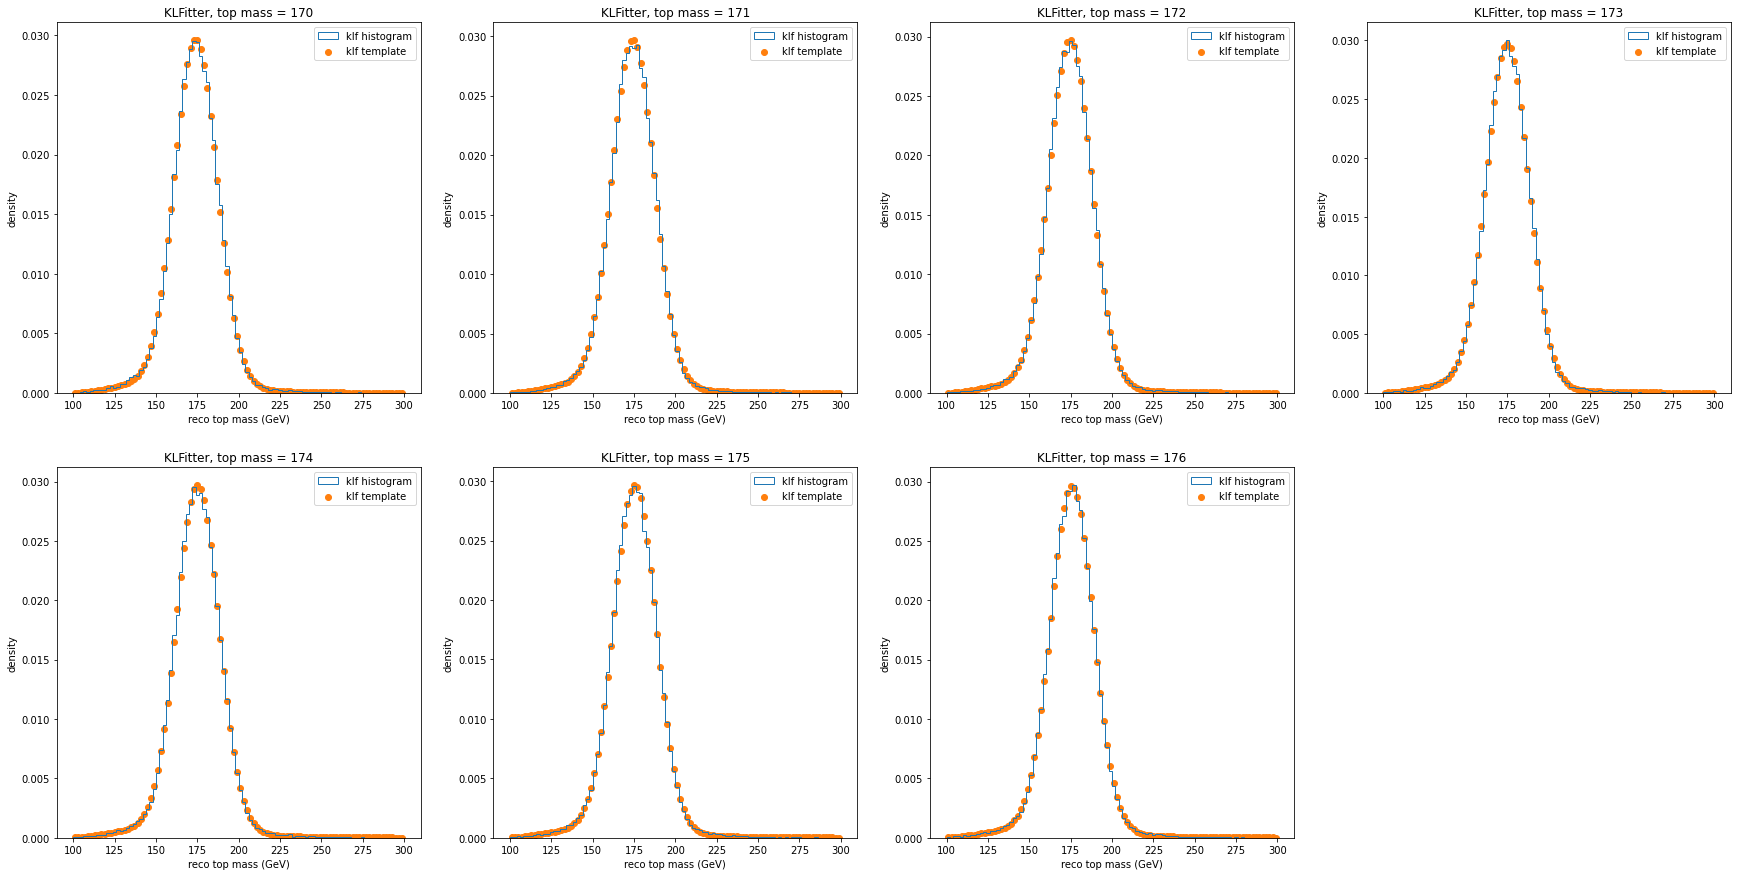

In [18]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    hist, bin_edges = np.histogram(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>-70))], bins=bins, density=True)
    klf_template = combine_klf_pdf(m)
    plt.hist(reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], loglikeli_klf_dic[m]>-70))], bins=bins, density=True, histtype='step', label='klf histogram')
    plt.scatter(bins[:-1]+1, klf_template, label='klf template')
    plt.title('KLFitter, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

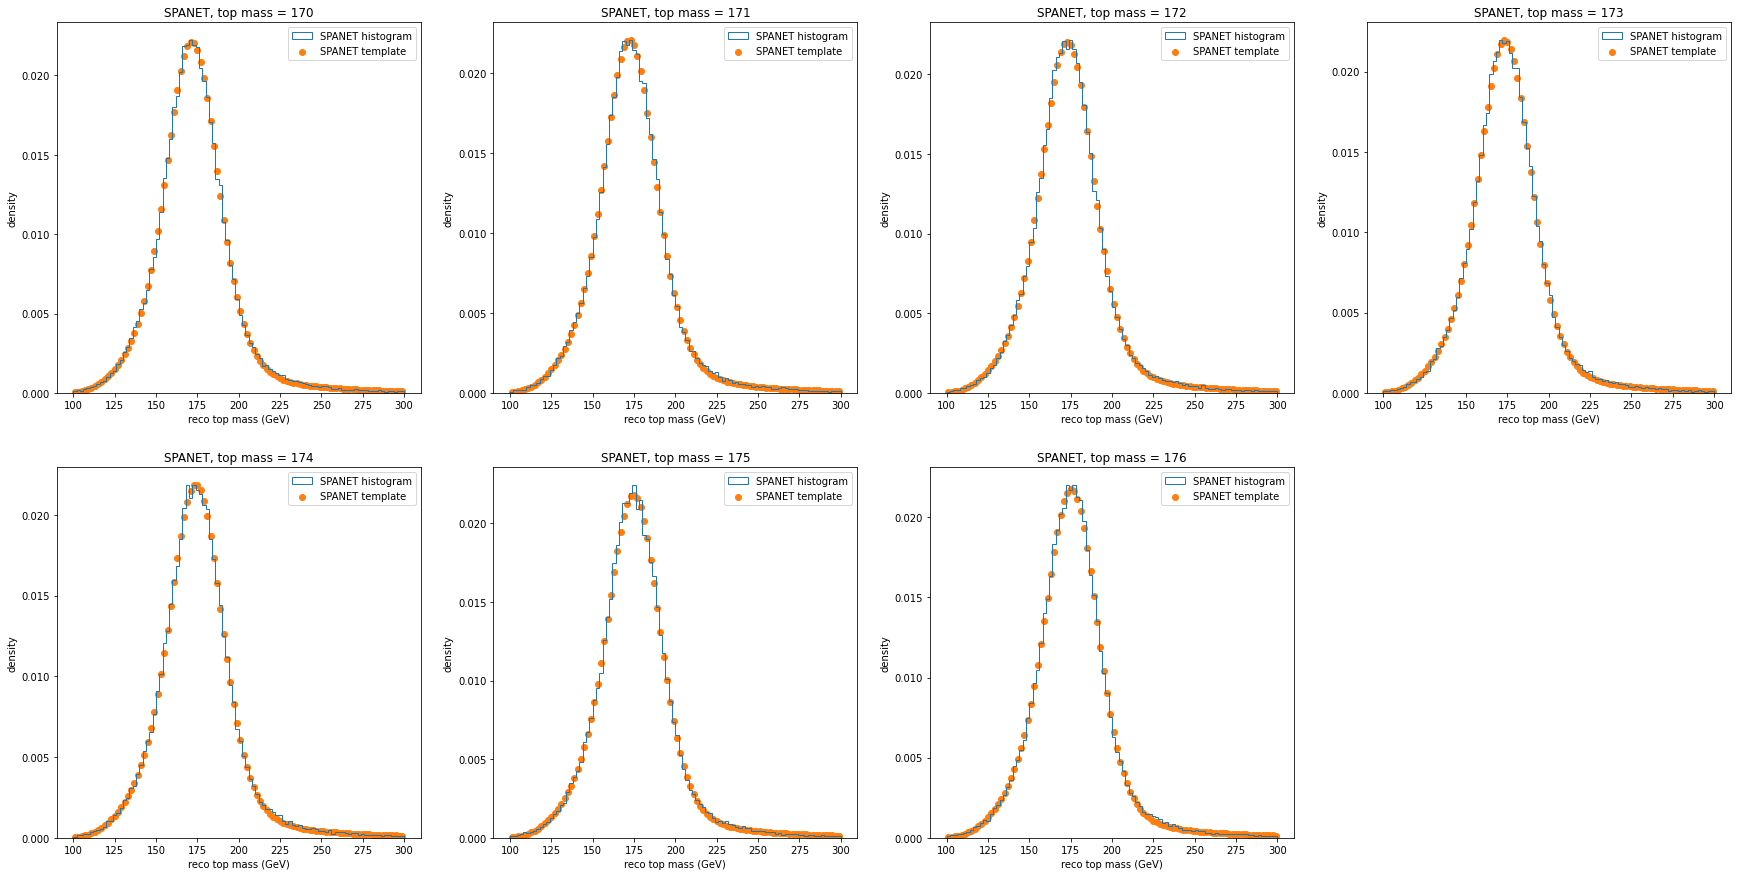

In [19]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    hist, bin_edges = np.histogram(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], loglikeli_klf_dic[m]>-70))], bins=bins, density=True)
    spanet_template = combine_spanet_pdf(m)
    plt.hist(reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], loglikeli_klf_dic[m]>-70))], bins=bins, density=True, histtype='step', label='SPANET histogram')
    plt.scatter(bins[:-1]+1, spanet_template, label='SPANET template')
    plt.title('SPANET, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [21]:
top_mass_arr = np.linspace(170, 176, 1000)
reco_klf = reco_klf_dic[173][np.logical_and.reduce((cut_klf_dic[173], loglikeli_klf_dic[173]>-70))]
chi2_klf_arr = [chi2_pdf(reco_klf, combine_klf_pdf(m)) for m in top_mass_arr]
reco_spanet = reco_spanet_dic[173][np.logical_and.reduce((cut_spanet_dic[173], loglikeli_klf_dic[173]>-70))]
chi2_spanet_arr = [chi2_pdf(reco_spanet, combine_spanet_pdf(m)) for m in top_mass_arr]

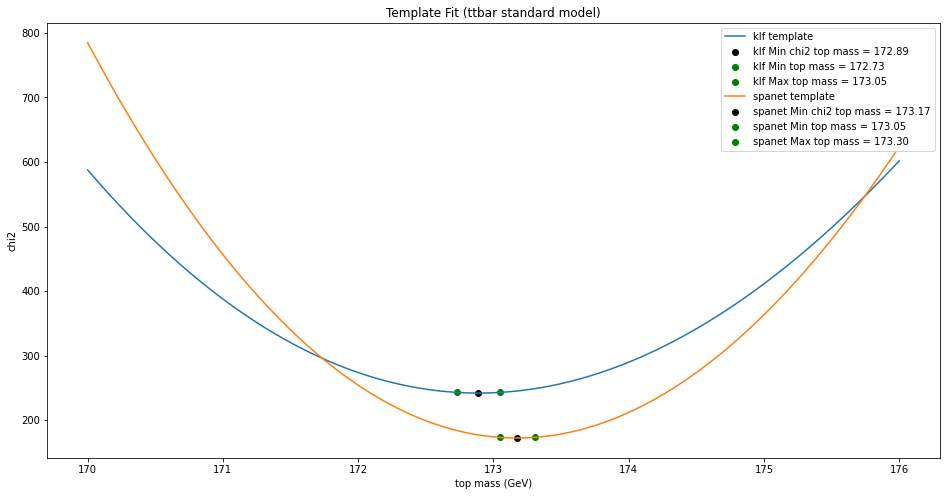

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(top_mass_arr, chi2_klf_arr, label='klf template')
min_loc = [top_mass_arr[np.argmin(chi2_klf_arr)], min(chi2_klf_arr)]
passed_chi2_klf_arr = [chi2 for chi2 in chi2_klf_arr if chi2 < min(chi2_klf_arr)+1]
plt.scatter(min_loc[0], min_loc[1], c='k', label = 'klf Min chi2 top mass = {:.2f}'.format(min_loc[0]))
plt.scatter(top_mass_arr[chi2_klf_arr.index(passed_chi2_klf_arr[0])], passed_chi2_klf_arr[0], c='g', label='klf Min top mass = {:.2f}'.format(top_mass_arr[chi2_klf_arr.index(passed_chi2_klf_arr[0])]))
plt.scatter(top_mass_arr[chi2_klf_arr.index(passed_chi2_klf_arr[-1])], passed_chi2_klf_arr[0], c='g', label='klf Max top mass = {:.2f}'.format(top_mass_arr[chi2_klf_arr.index(passed_chi2_klf_arr[-1])]))

plt.plot(top_mass_arr, chi2_spanet_arr, label='spanet template')
min_loc = [top_mass_arr[np.argmin(chi2_spanet_arr)], min(chi2_spanet_arr)]
passed_chi2_spanet_arr = [chi2 for chi2 in chi2_spanet_arr if chi2 < min(chi2_spanet_arr)+1]
plt.scatter(min_loc[0], min_loc[1], c='k', label = 'spanet Min chi2 top mass = {:.2f}'.format(min_loc[0]))
plt.scatter(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[0])], passed_chi2_spanet_arr[0], c='g', label='spanet Min top mass = {:.2f}'.format(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[0])]))
plt.scatter(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[-1])], passed_chi2_spanet_arr[0], c='g', label='spanet Max top mass = {:.2f}'.format(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[-1])]))

plt.title('Combined pdf chi2 (ttbar mass variation 173 GeV)')
plt.xlabel('top mass (GeV)')
plt.ylabel('chi2')
plt.legend(loc='upper right')
plt.show()

In [ ]:
scipy.optimize.minimize()